# ECE 157A/272A Fall 2023 Homework 2

Name:

In [ ]:
import os
import typing
from typing import Tuple

import numpy as np
import pandas as pd

# OpenCV and Scikit-Image for image manipulation
import cv2
from skimage.transform import resize
from skimage.measure import label, regionprops, perimeter

# Seaborn and Matplotlib for plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-Learn Descision Tree and helper functions
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, homogeneity_score, completeness_score

FAIL = 2 # failing die
PASS = 1 # passing die
NO_DIE = 0 # no die
RANDOM_SEED = 10

### Helper Functions

In [ ]:
# TODO: Implement a function that takes a wafer map and outputs it to a directory with the given name
def output_image(wafer_map: np.ndarray, name: str, dir: str, vmin: int=0, vmax: int=2) -> None:
  if not os.path.exists(dir):
    os.makedirs(dir)
    # Construct the full path where the image will be saved
    file_path = os.path.join(dir, name)

    # Save the wafer map as an image
    plt.imsave(file_path, wafer_map, cmap='viridis', vmin=vmin, vmax=vmax)

    return

# TODO: Implement a function that outputs all wafer maps to corresponding failure type directories
def output_all_wafer_maps(df: pd.DataFrame) -> None:
  for index, row in df.iterrows():
    # Extract wafer map, failure type, lot name, and wafer index
    wafer_map = row['waferMap']
    failure_type = row['failureType']
    lot_name = row['lotName']
    wafer_index = row['waferIndex']

    # Construct directory name and image file name
    dir_name = os.path.join('output', str(failure_type))
    image_name = f"{lot_name}-{wafer_index}.png"

    # Output the wafer map to the corresponding directory
    output_image(wafer_map, image_name, dir_name)



In [ ]:
# TODO: Implement a function that generate a single plot showing one wafer map example from each failure type
def visualize_failure_types(df: pd.DataFrame, figsize=(16,9)) -> None:
    # Find unique failure types within the "failureType" column of the df
    unique_failure_types = df['failureType'].unique()

    # Determine the number of rows and columns for the subplot based on the number of unique failure types
    n_cols = 3
    n_rows = int(np.ceil(len(unique_failure_types) / n_cols))

    # Create plt canvas with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Iterate through all the failure types and show one wafer map per class
    for i, failure_type in enumerate(unique_failure_types):
        # Pick the first image from each category
        example_df = df[df['failureType'] == failure_type].iloc[0]

        # Get the wafer map
        wafer_map = example_df['waferMap']

        # Plot image on the axes
        ax = axes[i]
        ax.imshow(wafer_map, cmap='viridis')  # 'viridis' colormap is just an example, you can use a different one
        ax.set_title(f'Failure Type: {failure_type}')
        ax.axis('off')  # Hide axes ticks

    # If there are any remaining subplots, turn them off
    for j in range(i+1, n_rows * n_cols):
        axes[j].axis('off')

    # Adjust layout to be tight
    plt.tight_layout()

    # Show the plot
    plt.show()


### Load Dataset

In [ ]:
# load training dataset as pandas dataframe
np_train = np.load('wafermap_train.npy', allow_pickle=True)
df_train = pd.DataFrame.from_records(np_train)


### Dataset Inspection

In [ ]:
# use pandas to inspect the dataset information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2746 entries, 0 to 2745
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dieSize         2746 non-null   float64
 1   failureType     2746 non-null   object 
 2   lotName         2746 non-null   object 
 3   trainTestLabel  2746 non-null   object 
 4   waferIndex      2746 non-null   float64
 5   waferMap        2746 non-null   object 
dtypes: float64(2), object(4)
memory usage: 128.8+ KB


In [ ]:
# inspect the dieSize
# notice that the die size varies?
# We will need to preprocess them to make it uniform
df_train['dieSize'].value_counts()

1334.0    300
1226.0    191
1801.0    177
1080.0    176
2393.0    129
         ... 
1153.0      1
3858.0      1
6547.0      1
1668.0      1
2470.0      1
Name: dieSize, Length: 255, dtype: int64

<Axes: >

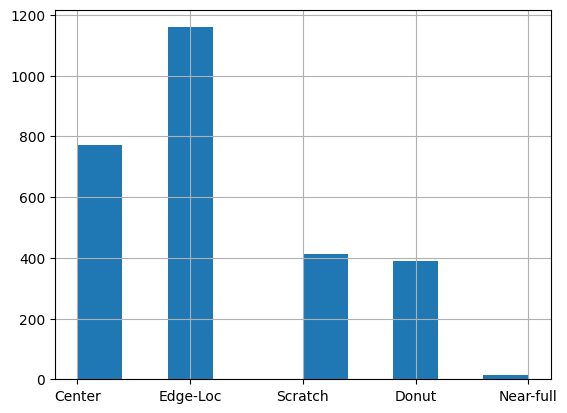

In [ ]:
# inspect the failure types and the distributions
df_train['failureType'].hist()

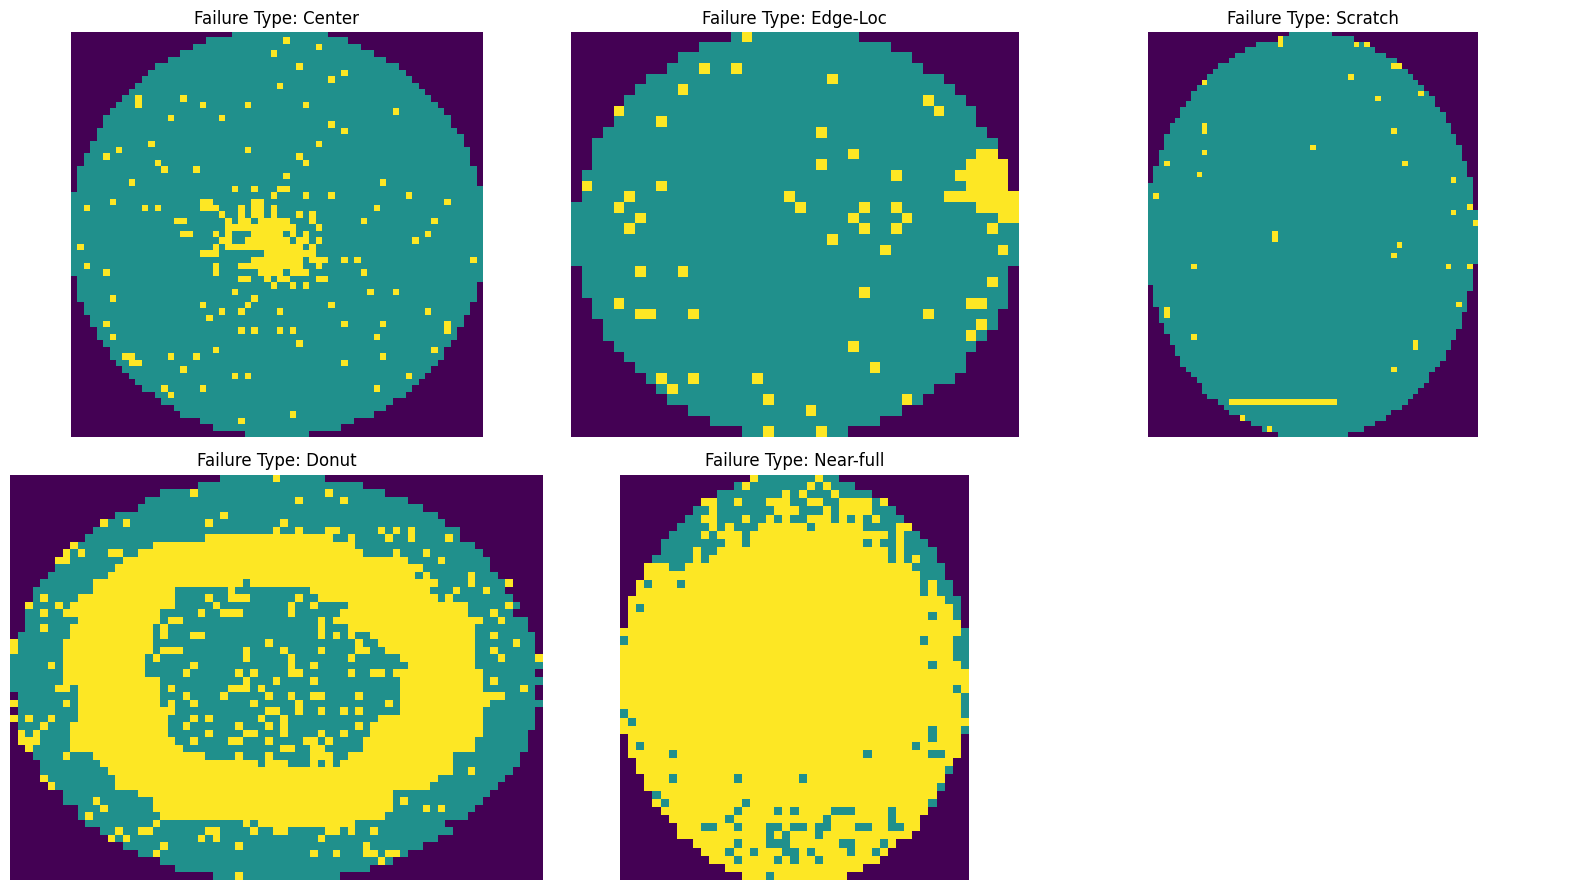

In [ ]:
# show a wafermap in each class
visualize_failure_types(df_train)

In [ ]:
# output all images to failure type directory
root_dir = 'defect_types'
output_all_wafer_maps(df_train)

### Data Preparation (Part 1)

For data preparation, we need to perform the following operations:
1) Resize the wafer maps as a numpy array of shape [x, 64, 64]
2) Convert the labels into numeric values

In [ ]:
# TODO: The function takes the failure type string
# and returns the numeric value of failureType
def convert_failure_type(failure_type: str) -> int:
    # Create dictionary for converting string to numeric number based on the provided failure types
    string2int = {
        'Center': 1,
        'Edge-Loc': 2,
        'Scratch': 3,
        'Donut': 4,
        'Near-full': 5
    }

    return string2int.get(failure_type, -1)  # Return -1 for unknown failure types


# TODO: The function resizes a wafer to specified output shape using opencv's resize function
def resize_wafer_map(wafer_map: np.ndarray, output_shape: tuple = (64, 64)) -> np.ndarray:
    # Resize the wafer map using OpenCV's resize function
    resized_wafer_map = cv2.resize(wafer_map, output_shape, interpolation=cv2.INTER_NEAREST)
    return resized_wafer_map

# create dataframe columns to store the return values of the two tasks below:
#       (1) reshapes the wafer maps as a numpy array of shape (64, 64),
#       (2) and converts the failureType into numeric values
def prepare_data(df: pd.DataFrame, has_labels: bool=True) -> Tuple[np.ndarray, list]:
    # Resize_wafer_map function to resize the wafer map to a larger size
    # note: here we decided to overwrite the waferMap column, but for best
    # practice, it's best to create a new column unless you don't need the original
    # wafer map data anymore
    df['waferMap'] = df['waferMap'].apply(resize_wafer_map)
    if(has_labels):
        df['failureTypeInt'] = df['failureType'].apply(convert_failure_type)
    return df


Prepare the data with the above function

In [ ]:
# actually resizing the wafer map and converting failure types
# in the training dataframe
df_train = prepare_data(df_train)

### Feature Engineering
Extract features from the wafer maps

In [ ]:
# The function that detects connect components using skimage
# and selects one with the largest area which we call salient region
# TODO: skip to the create_feature_columns code block and generate salient region
# before proceeding to other feature extractor functions
# https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
# https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

def get_salient_region(row: pd.Series) -> np.ndarray:
    # get wafer map from dataframe row
    wafer_map = row['waferMap']

    # create a wafer map with NO_DIE as background and FAIL as defect
    failure_only = np.zeros_like(wafer_map)
    failure_only[wafer_map==FAIL] = FAIL

    # label the connected components and get their regions properties
    # note: you might want to plot the labeled_image to take a look at the
    # return of the label function
    labeled_image = label(failure_only, background=NO_DIE, connectivity=2)
    region_props = regionprops(labeled_image)

    # returns the largest connected component as salient region
    # note: label image starts connected component label at value 1 with background being 0
    # thus, we need to add 1 after argmax
    largest_region_label = np.argmax([prop.area for prop in region_props]) + 1
    salient_region = np.zeros_like(labeled_image)
    salient_region[labeled_image == largest_region_label] = FAIL

    # # uncomment to verify the salient region
    # fig, ax = plt.subplots(nrows=1, ncols=2)
    # ax[0].imshow(wafer_map)
    # ax[1].imshow(salient_region)
    # plt.show()

    return salient_region

def get_area_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    wafer_map = row['waferMap']
    salient_region = row['salientRegion']

    # count the number of fail dice on salient region
    fail_dice_in_salient = np.sum(salient_region)

    # count the total number of dice on wafer map
    total_dice = np.sum(wafer_map)

    # divide them to get area_ratio
    if total_dice == 0:  # to avoid division by zero
        area_ratio = 0
    else:
        area_ratio = fail_dice_in_salient / total_dice

    return area_ratio

# TODO: The function returns the ratio of the perimeter of the salient region to the radius of the wafer map
def get_perimeter_ratio(row: pd.Series) -> float:
    # Retrieve wafer map and salient region from dataframe row
    wafer_map = row['waferMap']
    salient_region = get_salient_region(row)

    # Label the salient region connected components and get their regions properties
    labeled_image = label(salient_region, background=0, connectivity=2)
    region_props = regionprops(labeled_image)
    # Assuming only one connected component (the largest one)
    salient_perimeter = region_props[0].perimeter

    # Find wafer map radius
    # Assuming wafer map is a square/rectangle, the radius would be half of its diagonal
    wafer_radius = np.sqrt(wafer_map.shape[0]**2 + wafer_map.shape[1]**2) / 2

    # Divide them to get ratio
    perimeter_ratio = salient_perimeter / wafer_radius

    return perimeter_ratio

# TODO: The function returns the maximal distance between the salient region and
# the center of the wafer map
def get_max_dist_from_center(row: pd.Series) -> float:
    # Retrieve wafer map and salient region from dataframe row
    wafer_map = row['waferMap']
    salient_region = get_salient_region(row)

    # Find center of the wafer map
    center_y, center_x = wafer_map.shape[0] / 2, wafer_map.shape[1] / 2

    # Get all coordinates of the salient region and compute the max distance from center
    coords = np.argwhere(salient_region != 0)  # Getting all non-zero coordinates
    distances = np.sqrt((coords[:, 0] - center_y)**2 + (coords[:, 1] - center_x)**2)
    max_distance = np.max(distances)

    return max_distance


# TODO: The function returns the minimal distance between the salient region and
# the center of the wafer map
def get_min_dist_from_center(row: pd.Series) -> float:
    # Retrieve wafer map and salient region from dataframe row
    wafer_map = row['waferMap']
    salient_region = get_salient_region(row)

    # Find center of the wafer map
    center_y, center_x = wafer_map.shape[0] / 2, wafer_map.shape[1] / 2

    # Get all coordinates of the salient region and compute the min distance from center
    coords = np.argwhere(salient_region != 0)  # Getting all non-zero coordinates
    distances = np.sqrt((coords[:, 0] - center_y)**2 + (coords[:, 1] - center_x)**2)
    min_distance = np.min(distances)

    return min_distance


# TODO: The function returns the ratio of the length of the major axis of the estimated
# ellipse surrounding the salient region to the radius of the wafer map

def get_major_axis_ratio(row: pd.Series) -> float:
    # Retrieve wafer map and salient region from dataframe row
    wafer_map = row['waferMap']
    salient_region = get_salient_region(row)

    # Label the salient region connected components and get their regions properties
    labeled_image = label(salient_region)
    region_props = regionprops(labeled_image)

    # Assuming that there's only one major salient region for the failure,
    # Get the major axis length of the salient region
    major_axis_length = region_props[0].major_axis_length

    # Find the wafer map radius, assuming it's a circle
    wafer_radius = wafer_map.shape[0] / 2

    # Calculate the major axis ratio
    major_axis_ratio = major_axis_length / wafer_radius

    return major_axis_ratio

def get_minor_axis_ratio(row: pd.Series) -> float:
    # Retrieve wafer map and salient region from dataframe row
    wafer_map = row['waferMap']
    salient_region = get_salient_region(row)

    # Label the salient region connected components and get their regions properties
    labeled_image = label(salient_region)
    region_props = regionprops(labeled_image)

    # Assuming that there's only one major salient region for the failure,
    # Get the minor axis length of the salient region
    minor_axis_length = region_props[0].minor_axis_length

    # Find the wafer map radius, assuming it's a circle
    wafer_radius = wafer_map.shape[0] / 2

    # Calculate the minor axis ratio
    minor_axis_ratio = minor_axis_length / wafer_radius

    return minor_axis_ratio


#TODO: The function returns the solidity, indicating the proportion of defective dice
# in the estimated convex hull of the salient region
def get_solidity(row: pd.Series) -> float:
    # Retrieve wafer map and salient region from dataframe row
    wafer_map = row['waferMap']
    salient_region = get_salient_region(row)

    # Label the salient region connected components and get their regions properties
    labeled_image = label(salient_region)
    region_props = regionprops(labeled_image)

    # Assuming there's only one major salient region for the failure,
    # Get the solidity of the salient region
    solidity = region_props[0].solidity

    return solidity

# TODO: The function returns the eccentricity of the salient region
def get_eccentricity(row: pd.Series) -> float:
    # Retrieve wafer map and salient region from dataframe row
    wafer_map = row['waferMap']
    salient_region = get_salient_region(row)

    # Label the salient region connected components and get their regions properties
    labeled_image = label(salient_region)
    region_props = regionprops(labeled_image)

    # Assuming there's only one major salient region for the failure,
    # Get the eccentricity of the salient region
    eccentricity = region_props[0].eccentricity

    return eccentricity

# TODO: The function returns the ratio of the failed dice on the wafer map to the total
# number of dice on the wafer map
def get_yield_loss(row: pd.Series) -> float:
    # retrieve wafer map
    wafer_map = row['waferMap']

    # count FAIL dice and total number of dice
    fail_dice = np.sum(wafer_map == FAIL)
    total_dice = wafer_map.size

    # compute yield loss
    yield_loss = fail_dice / total_dice

    return yield_loss


# TODO: The function returns the ratio of the failed dice on the outermost two rings of the
# wafer map to the total number of dice on the outermost two rings of the wafer map
def get_edge_yield_loss(row: pd.Series) -> float:
    # retrieve wafer map
    wafer_map = row['waferMap']

    # find ring label that highlights the outermost two rings of the wafer
    labeled_image = ring_label_from_outside(wafer_map)

    # get edge FAIL dice and total number of edge dice
    edge_fail_dice = np.sum((wafer_map == FAIL) & (labeled_image == 1))
    total_edge_dice = np.sum(labeled_image == 1)

    edge_yield_loss = edge_fail_dice / total_edge_dice if total_edge_dice != 0 else 0

    return edge_yield_loss



# TODO: This helper function returns return an numpy array highlighting the outermost two rings
# of the wafer map with nonzero value
from skimage.morphology import erosion, disk

def ring_label_from_outside(wafer_map: np.ndarray) -> np.ndarray:
    # Erode the wafer map using a disk structuring element of a certain radius.
    # The radius can be adjusted depending on the thickness of the desired ring.
    eroded_map = erosion(wafer_map, disk(2))

    # Subtract the eroded map from the original map to isolate the outermost rings
    ring_labels = wafer_map - eroded_map

    return ring_labels



In [ ]:
# # uncomment to use test codes for feature extractor functions
failure_type = 'Center'
row_index = 0
row = df_train.loc[df_train['failureType']==failure_type].iloc[row_index]

print(get_salient_region(row))
print(get_area_ratio(row))
print(get_max_dist_from_center(row))
print(get_min_dist_from_center(row))
print(get_perimeter_ratio(row))
print(get_major_axis_ratio(row))
print(get_minor_axis_ratio(row))
print(get_solidity(row))
print(get_eccentricity(row))
print(get_yield_loss(row))
print(get_edge_yield_loss(row))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.0669772859638905
13.200378782444085
0.5
1.6451149459288434
0.6078603446548649
0.34795905632390955
0.5665024630541872
0.819951802481801
0.057291666666666664
0.44813278008298757


In [ ]:
def create_feature_columns(df: pd.DataFrame) -> pd.DataFrame:
    df['salientRegion'] = df.apply(get_salient_region, axis=1)
    df['areaRatio'] = df.apply(get_area_ratio, axis=1)
    df['perimeterRatio'] = df.apply(get_perimeter_ratio, axis=1)
    df['maxDistFromCenter'] = df.apply(get_max_dist_from_center, axis=1)
    df['minDistFromCenter'] = df.apply(get_min_dist_from_center, axis=1)
    df['majorAxisRatio'] = df.apply(get_major_axis_ratio, axis=1)
    df['minorAxisRatio'] = df.apply(get_minor_axis_ratio, axis=1)
    df['solidity'] = df.apply(get_solidity, axis=1)
    df['eccentricity'] = df.apply(get_eccentricity, axis=1)
    df['yieldLoss'] = df.apply(get_yield_loss, axis=1)
    df['edgeYieldLoss'] = df.apply(get_edge_yield_loss, axis=1)

    return df


In [ ]:
# actually applying the feature extractors on the training dataframe
df_train = create_feature_columns(df_train)

Failure Class: Center
Area Ratio: 0.28
Perimeter Ratio: 4.43
Max Distance from Center: 10.30
Min Distance from Center: 0.00
Major Axis Ratio: 0.99
Minor Axis Ratio: 0.91
Solidity: 0.74
Eccentricity: 0.39
Yield Loss: 0.19
Edge Yield Loss: 0.62
--------------------------------------------------


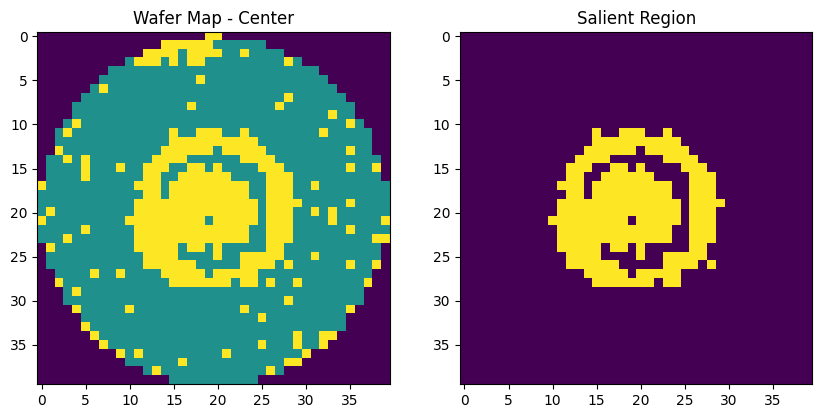

Failure Class: Edge-Loc
Area Ratio: 0.02
Perimeter Ratio: 0.46
Max Distance from Center: 28.69
Min Distance from Center: 27.23
Major Axis Ratio: 0.56
Minor Axis Ratio: 0.07
Solidity: 0.70
Eccentricity: 0.99
Yield Loss: 0.03
Edge Yield Loss: 0.18
--------------------------------------------------


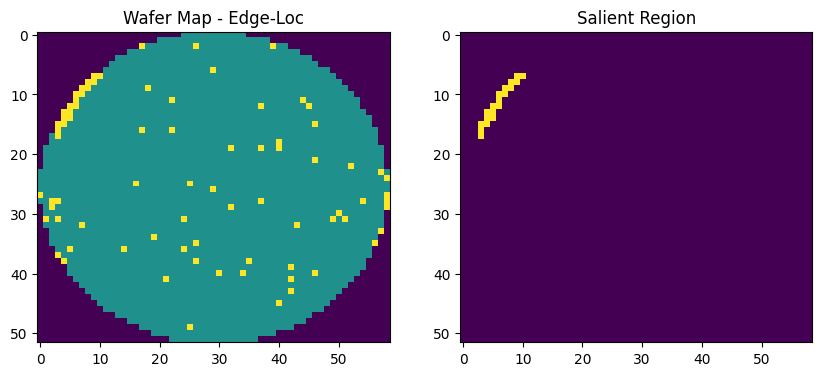

Failure Class: Scratch
Area Ratio: 0.01
Perimeter Ratio: 0.47
Max Distance from Center: 25.81
Min Distance from Center: 10.55
Major Axis Ratio: 0.97
Minor Axis Ratio: 0.05
Solidity: 0.52
Eccentricity: 1.00
Yield Loss: 0.04
Edge Yield Loss: 0.29
--------------------------------------------------


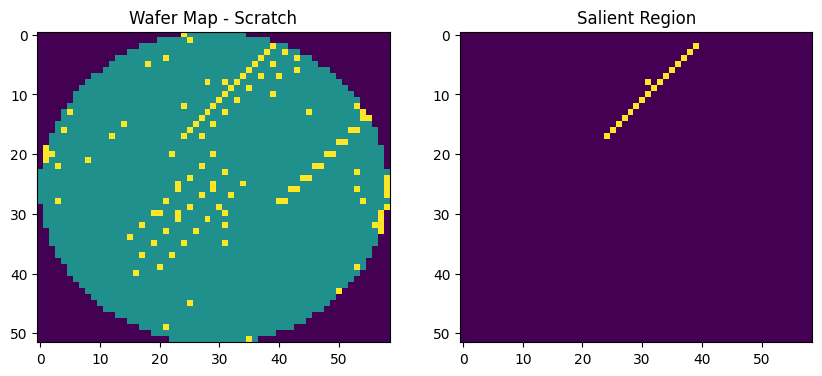

Failure Class: Donut
Area Ratio: 0.47
Perimeter Ratio: 7.48
Max Distance from Center: 16.29
Min Distance from Center: 3.20
Major Axis Ratio: 1.58
Minor Axis Ratio: 1.36
Solidity: 0.64
Eccentricity: 0.52
Yield Loss: 0.34
Edge Yield Loss: 0.79
--------------------------------------------------


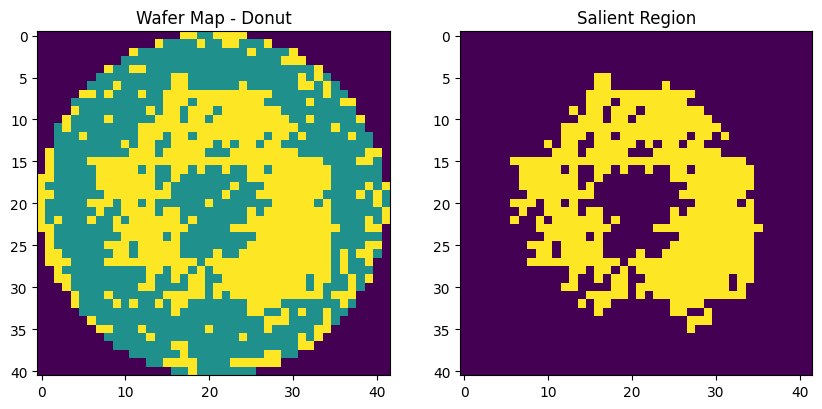

Failure Class: Near-full
Area Ratio: 0.99
Perimeter Ratio: 8.07
Max Distance from Center: 22.07
Min Distance from Center: 0.50
Major Axis Ratio: 2.01
Minor Axis Ratio: 1.93
Solidity: 0.96
Eccentricity: 0.28
Yield Loss: 0.77
Edge Yield Loss: 1.00
--------------------------------------------------


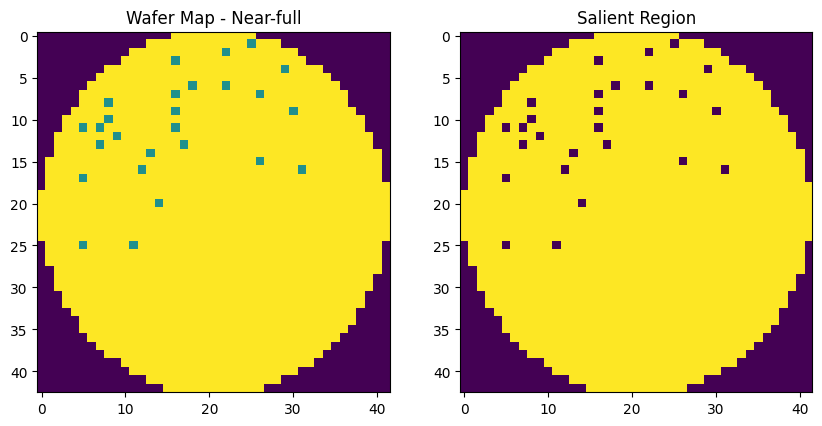

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df=df_train
# Assuming df is your dataframe with 'waferMap' column and 'failureType' column
unique_failure_classes = df['failureType'].unique()

for failure_class in unique_failure_classes:
    sample_failure = df[df['failureType'] == failure_class].sample(1).iloc[0]

    wafer_map = sample_failure['waferMap']
    salient_region = get_salient_region(sample_failure)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].imshow(wafer_map)
    axes[0].set_title(f"Wafer Map - {failure_class}")

    axes[1].imshow(salient_region)
    axes[1].set_title("Salient Region")

    print(f"Failure Class: {failure_class}")
    print(f"Area Ratio: {get_area_ratio(sample_failure):.2f}")
    print(f"Perimeter Ratio: {get_perimeter_ratio(sample_failure):.2f}")
    print(f"Max Distance from Center: {get_max_dist_from_center(sample_failure):.2f}")
    print(f"Min Distance from Center: {get_min_dist_from_center(sample_failure):.2f}")
    print(f"Major Axis Ratio: {get_major_axis_ratio(sample_failure):.2f}")
    print(f"Minor Axis Ratio: {get_minor_axis_ratio(sample_failure):.2f}")
    print(f"Solidity: {get_solidity(sample_failure):.2f}")
    print(f"Eccentricity: {get_eccentricity(sample_failure):.2f}")
    print(f"Yield Loss: {get_yield_loss(sample_failure):.2f}")
    print(f"Edge Yield Loss: {get_edge_yield_loss(sample_failure):.2f}")
    print("-"*50)

    plt.show()


### Data Preparation (Part 2)

prepare the dataset for training models

In [ ]:
# TODO: From the dataframe select the features we extracted as X
# and y is the numerical failure type labels
# CODE HERE
selected_features = [
    'areaRatio',
    'perimeterRatio',
    'maxDistFromCenter',
    'minDistFromCenter',
    'majorAxisRatio',
    'minorAxisRatio',
    'solidity',
    'eccentricity',
    'yieldLoss',
    'edgeYieldLoss'

]
X = df_train[selected_features]
y = df_train['failureType']
# TODO: split dataset into training and validation set
# we will set aside some portion of the training data as validation data
# CODE HERE
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


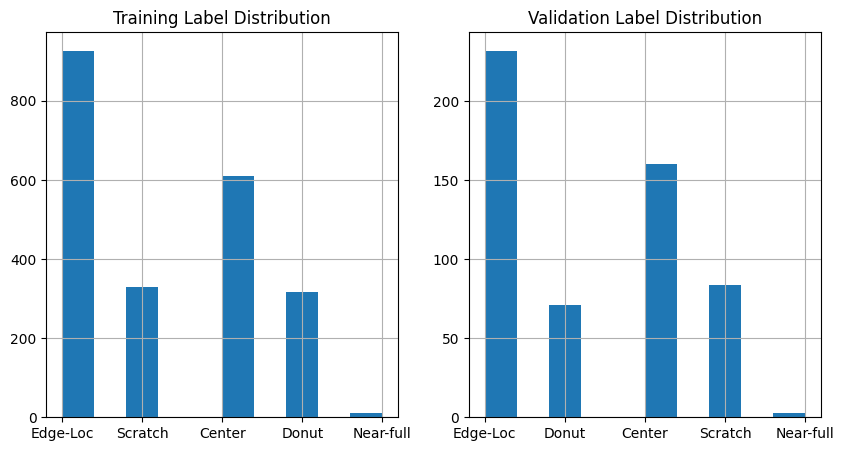

In [ ]:
# check train/validation distribution
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
y_train.hist()
plt.title('Training Label Distribution')

plt.subplot(1,2,2)
y_valid.hist()
plt.title('Validation Label Distribution')

plt.show()

Train and Evaluate a Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree classifier with max tree depth of 3
classifier = DecisionTreeClassifier(max_depth=3)

# Train the Decision Tree classifier with the training data
classifier.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=3)

In [ ]:
def calculate_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray) -> float:
    correct_predictions = np.sum(pred_labels == true_labels)
    total_predictions = len(true_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy

def calculate_per_class_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray) -> dict:
    classes = np.unique(true_labels)
    accuracies = {}
    for cls in classes:
        cls_true = true_labels[true_labels == cls]
        cls_pred = pred_labels[true_labels == cls]
        accuracies[cls] = np.sum(cls_true == cls_pred) / len(cls_true)
    return accuracies


Model accuracy on training data set is 89.21%
Model accuracy on training data set for each class is {'Center': 0.9705400981996727, 'Donut': 0.7192429022082019, 'Edge-Loc': 0.9439050701186623, 'Near-full': 1.0, 'Scratch': 0.7629179331306991}%


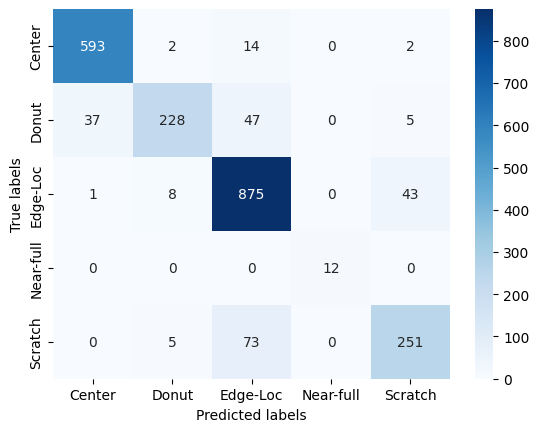

In [ ]:
# 1. Predict labels for the training data
predicted_labels_train = classifier.predict(X_train)

# 2. Calculate the accuracy of the model on the training data
acc_train = calculate_accuracy(predicted_labels_train, y_train) * 100

print(f'Model accuracy on training data set is {acc_train:.2f}%')

# 3. Calculate the per-class accuracy
accuracies_train = calculate_per_class_accuracy(predicted_labels_train, y_train)

print(f'Model accuracy on training data set for each class is {accuracies_train}%')

# 4. Compute the confusion matrix
cm = confusion_matrix(y_train, predicted_labels_train)

# 5. Plot the confusion matrix using a heatmap

# Assuming failure types are [1, 2, 3, ...]
# Modify this if your labels are different
tick_labels = sorted(np.unique(y_train))

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=tick_labels,
            yticklabels=tick_labels,
            cmap='Blues')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Model accuracy on validation data set is 89.27%
Model accuracy on validation data set for each class is {'Center': 0.975, 'Donut': 0.7323943661971831, 'Edge-Loc': 0.9439655172413793, 'Near-full': 1.0, 'Scratch': 0.7261904761904762}%


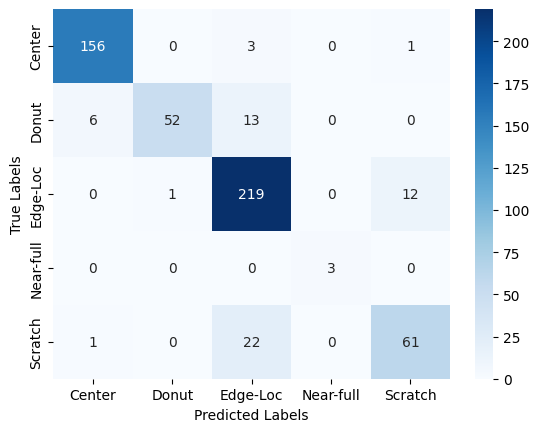

In [ ]:
# TODO: get the predicted labels of the validation data and calculate the accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
predicted_labels_valid = classifier.predict(X_valid)

# 2. Calculate accuracy for the validation set
acc_valid = accuracy_score(y_valid, predicted_labels_valid) * 100

print(f'Model accuracy on validation data set is {acc_valid:.2f}%')

# 3. Calculate the accuracy for each failure type.
# Assuming you've defined 'calculate_per_class_accuracy' as per your earlier prompt
accuracies_valid = calculate_per_class_accuracy(predicted_labels_valid, y_valid)

print(f'Model accuracy on validation data set for each class is {accuracies_valid}%')

# 4. Get failure types string sorted by their numerical value
# Assuming you have a mapping for failure types:
# tick_labels = [mapping[i] for i in sorted(mapping.keys())]

# 5. Compute the confusion matrix
cm = confusion_matrix(y_valid, predicted_labels_valid)

# 6. Plotting the confusion matrix
tick_labels = [str(i) for i in sorted(np.unique(y_valid))]  # Replace with your actual mapping if you have one.

sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=tick_labels,
            yticklabels=tick_labels,
            cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

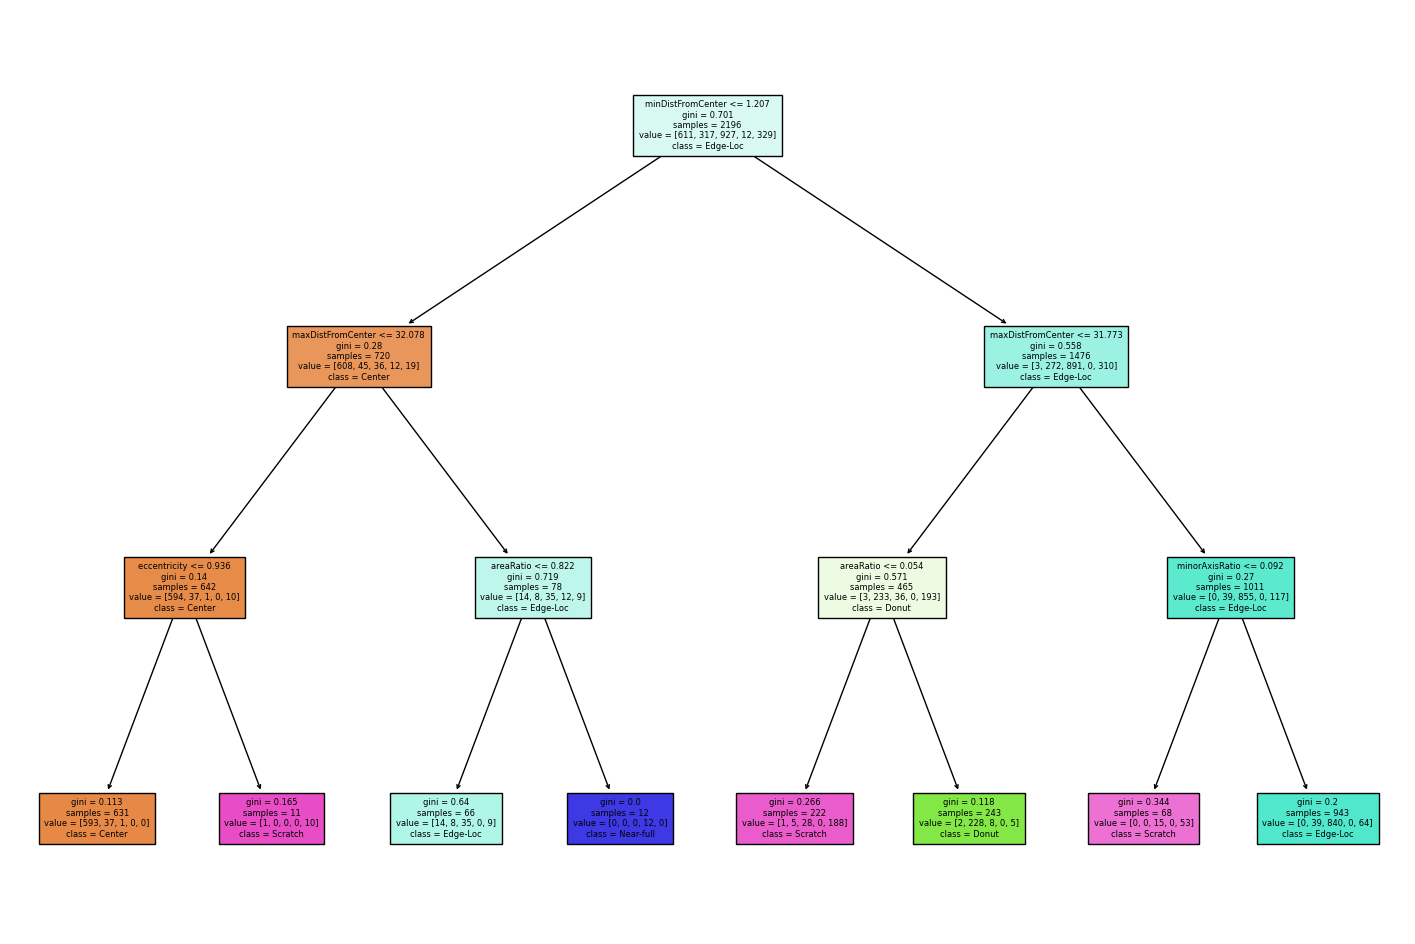

In [ ]:
# TODO: get failure types string sorted by their numerical value
class_names = [str(i) for i in sorted(np.unique(y_train))]

# plot decision tree
plt.figure(figsize=(18,12))
tree.plot_tree(classifier,                              # classifier to extract the rules from
                feature_names=selected_features,        # the feature names that were used
                class_names=class_names,                # the class labels, converted to string
                filled=True, fontsize=6)
plt.show()

### Testing Set

Data Loading, Preprocess, and Feature Extraction

In [ ]:
# TODO: load test dataset with pandas from wafermap_test.npy
# CODE HERE
test_data = np.load('wafermap_test.npy', allow_pickle=True)
test_df = pd.DataFrame(test_data)
# TODO: apply data preparation function
# note: test data does not have failureType column
# CODE HERE
test_df = prepare_data(test_df,has_labels=False)
# TODO: apply feature exatractors to extract features
# CODE HERE
test_df = create_feature_columns(test_df)


Generate Predictions for the Test Set

In [ ]:
X = test_df[selected_features]

# Get the predicted labels of the test data
predicted_labels = classifier.predict(X)


# Create a DataFrame to store the predicted failure types
scores_df = pd.Series(predicted_labels,name='failureType')

# Save the DataFrame to a CSV file
scores_df.to_csv('dt_scores.csv', index=False)


SVC

Training Classification Report:
              precision    recall  f1-score   support

      Center       0.87      0.99      0.93       611
    Edge-Loc       0.93      0.73      0.82       317
     Scratch       0.85      0.97      0.90       927
       Donut       0.00      0.00      0.00        12
   Near-full       0.97      0.58      0.73       329

    accuracy                           0.88      2196
   macro avg       0.72      0.65      0.67      2196
weighted avg       0.88      0.88      0.87      2196


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif



Validation Classification Report:
              precision    recall  f1-score   support

      Center       0.87      0.99      0.93       160
    Edge-Loc       0.89      0.66      0.76        71
     Scratch       0.83      0.96      0.89       232
       Donut       0.00      0.00      0.00         3
   Near-full       0.98      0.55      0.70        84

    accuracy                           0.86       550
   macro avg       0.71      0.63      0.66       550
weighted avg       0.87      0.86      0.85       550



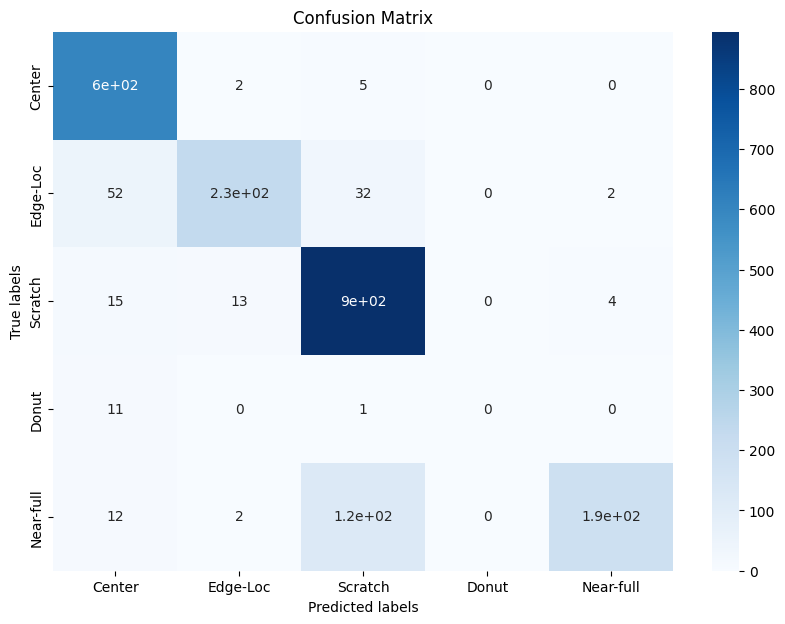

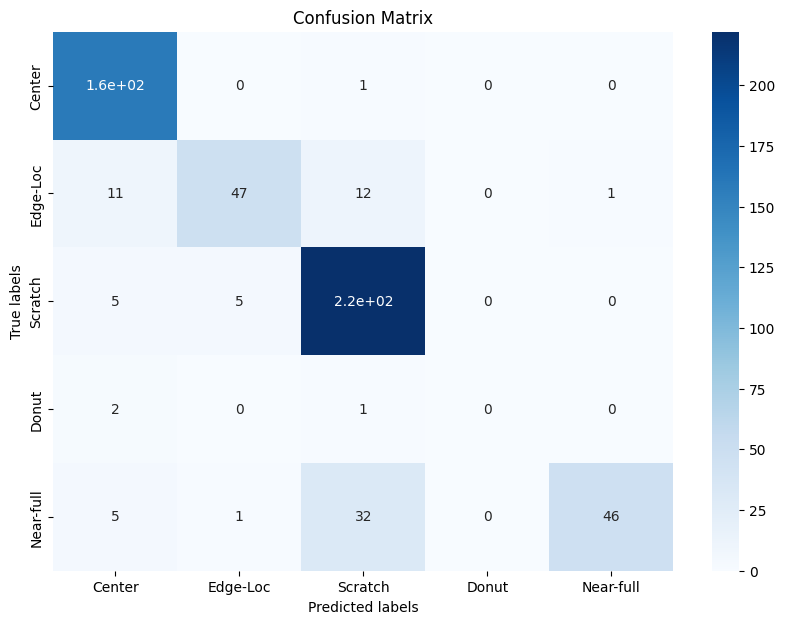

In [ ]:
from sklearn.svm import SVC
svc = SVC()
string2int = {
        'Center': 1,
        'Edge-Loc': 2,
        'Scratch': 3,
        'Donut': 4,
        'Near-full': 5
    }
# Assuming X_train is your training data and y_train are your labels
svc.fit(X_train, y_train)
from sklearn.metrics import classification_report

# Predict on training set
y_train_pred = svc.predict(X_train)

# Predict on validation set
# Assuming X_val is your validation data and y_val are your validation labels
y_val_pred = svc.predict(X_valid)

# Classification reports
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred, target_names=list(string2int.keys())))

print("\nValidation Classification Report:")
print(classification_report(y_valid, y_val_pred, target_names=list(string2int.keys())))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrices
classes = list(string2int.keys())

plot_confusion_matrix(y_train, y_train_pred, classes)
plot_confusion_matrix(y_valid, y_val_pred, classes)


In [ ]:
def calculate_per_failure_accuracy(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    total_samples_per_class = cm.sum(axis=1)
    correct_predictions_per_class = cm.diagonal()

    accuracy_per_class = correct_predictions_per_class / total_samples_per_class

    for c, acc in zip(classes, accuracy_per_class):
        print(f'Accuracy for {c}: {acc * 100:.2f}%')

print("Per Failure Type Accuracy for Training Samples:")
calculate_per_failure_accuracy(y_train, y_train_pred, classes)

print("\nPer Failure Type Accuracy for Validation Samples:")
calculate_per_failure_accuracy(y_valid, y_val_pred, classes)

Per Failure Type Accuracy for Training Samples:
Accuracy for Center: 98.85%
Accuracy for Edge-Loc: 72.87%
Accuracy for Scratch: 96.55%
Accuracy for Donut: 0.00%
Accuracy for Near-full: 58.36%

Per Failure Type Accuracy for Validation Samples:
Accuracy for Center: 99.38%
Accuracy for Edge-Loc: 66.20%
Accuracy for Scratch: 95.69%
Accuracy for Donut: 0.00%
Accuracy for Near-full: 54.76%


In [ ]:
X = test_df[selected_features]

# Get the predicted labels of the test data
predicted_labels = svc.predict(X)

# Create a DataFrame to store the predicted failure types
scores_svc = pd.Series(predicted_labels,name='failureType')

# Save the DataFrame to a CSV file
scores_svc.to_csv('svc_scores.csv', index=False)
